## Phylogeographic analysis of viral movements during the 10th EBOV outbreak, DRC, 2018-20

Author: James Hadfield

Date: Feb 2020, revised August 2020

In [145]:
%reset -f
from datetime import datetime
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon, PathPatch, Patch
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import stats
from collections import defaultdict
import json, csv

def ambiguous_date_to_date_range(mydate, fmt):
    sep = fmt.split('%')[1][-1]
    min_date, max_date = {}, {}
    today = datetime.today().date()

    for val, field  in zip(mydate.split(sep), fmt.split(sep+'%')):
        f = 'year' if 'y' in field.lower() else ('day' if 'd' in field.lower() else 'month')
        if 'XX' in val:
            if f=='year':
                return None, None
            elif f=='month':
                min_date[f]=1
                max_date[f]=12
            elif f=='day':
                min_date[f]=1
                max_date[f]=31
        else:
            min_date[f]=int(val)
            max_date[f]=int(val)
    max_date['day'] = min(max_date['day'], 31 if max_date['month'] in [1,3,5,7,8,10,12]
                                           else 28 if max_date['month']==2 else 30)
    lower_bound = datetime(year=min_date['year'], month=min_date['month'], day=min_date['day']).date()
    upper_bound = datetime(year=max_date['year'], month=max_date['month'], day=max_date['day']).date()
    return (lower_bound, upper_bound if upper_bound<today else today)

def numeric_date(dt_string):
    if not dt_string or dt_string=="None" or dt_string == 'XXXX-XX-XX':
        return None
    from calendar import isleap

    if 'XX' in dt_string:
        ambig_date = ambiguous_date_to_date_range(dt_string, "%Y-%m-%d")
        return (numeric_date(str(ambig_date[0]))+numeric_date(str(ambig_date[1])))/2;
    else:
        dt = datetime.strptime(dt_string, "%Y-%m-%d")
    days_in_year = 366 if isleap(dt.year) else 365
    try:
        res = dt.year + (dt.timetuple().tm_yday-0.5) / days_in_year
    except:
        res = None
    return res

def num_date_to_weeks(num_date):
    return num_date*52

lat_longs = {}
with open("../config/lat_longs.tsv") as fh:
    for line in fh:
        parts = line.strip().split("\t")
        if parts[0]=="health_zone":
            lat_longs[parts[1]] = [float(parts[2]),float(parts[3])]
del fh, line, parts

## https://github.com/mapado/haversine/blob/master/haversine/haversine.py
def haversine(deme1, deme2):
        
    # unpack latitude/longitude
    try:
        lat1, lng1 = lat_longs[deme1.lower()]
        lat2, lng2 = lat_longs[deme2.lower()]
    except KeyError:
        return None;

    # convert all latitudes/longitudes from decimal degrees to radians
    lat1 = math.radians(lat1)
    lng1 = math.radians(lng1)
    lat2 = math.radians(lat2)
    lng2 = math.radians(lng2)

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = math.sin(lat * 0.5) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(lng * 0.5) ** 2

    # mean earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius
    _AVG_EARTH_RADIUS_KM = 6371.0088
    
    return 2 * _AVG_EARTH_RADIUS_KM * math.asin(math.sqrt(d))
    
# Same function as in lags.ipynb
def get_health_zone_colour(hz):
    colours_per_hz = {
        "mabalako": "#87CEFF",
        "beni": "#3b9072",
        "oicha": "#b09977",
        "butembo": "#f05129",
        "lubero": "#922428",
        "katwa": "#f5bd42",
        "kalunguta": "#966eac",
        "kyondo": "#d2202e",
        "masereka": "#621748",
        "musienene": "#b7cb95",
        "mutwanga": "#1219e9",
        "vuhovi": "#32ca29",
        "mandima": "#e3337e",
        "komanda": "#000000",
        "tchomia": "#00ff00",
        "kayna": "#37d6dc",
        "biena": "#743700",
        "manguredjipa": "#274720",
        "bunia": "#810025",
        "goma": "#FFDD00",
        "nyiragongo": "#FF8F8F",
        "rwampara": "#221959",
        "ariwara": "#BEE900",
        "mambasa": "#9FBFFF",
        "mwenga": "#C74F9D",
        "alimbongo": "#84DCC6",
        "lolwa": "#bde2e2",
        "nyakunde": "#E2BDBD"
    }
    try:
        return colours_per_hz[hz.lower()]
    except KeyError:
        print("MISSING COLOUR FOR HZ", hz)
        return "black"
    
# deme ordering is via WHO Sit-Reps
demes_ordered = [
    ## SOUTH KIVU ##
    "Mwenga",
    ## NORTH KIVU ##
    "Alimbongo",
    "Beni",
    "Biena",
    "Butembo",
    "Goma",
    "Kalunguta",
    "Katwa",
    "Kayna",
    "Kyondo",
    "Lubero",
    "Mabalako",
    "Manguredjipa",
    "Masereka",
    "Musienene",
    "Mutwanga",
    "Nyiragongo",
    "Oicha",
    "Pinga",
    "Vuhovi",
    ## ITURI ##
    "Ariwara",
    "Bunia",
    "Komanda",
    "Lolwa",
    "Mambasa",
    "Mandima",
    "Nyakunde",
    "Rwampara",
    "Tchomia"
]

* Jump is a movement between Health Zones where both are inferred with high probability
    * Lots of Jumps are into tips (i.e. node count of the jump is one)
* Chains are jumps which are "transmitted" to another node in the tree (in the same HZ)
    * Thus, chains are a strict subset of jumps
* A "Route" is any observed jump between health zones (the donor has to be a chain, btw)
* Sinks (perhaps better named "receipients") are the collection of demes for which we have a jump into, and therefore a route.
Since these only consider high confidence inferences, we will miss some demes for which we have sequences (imagine an internal node with low confidence DTA and a single tip -- this isn't counted as a jump)
* Sources are the inverse of sinks. Perhaps better thought of as donors.

The demes listed in the results here will therefore ignore some demes for which we have sequences, simply because we don't have any confidence in how the virus arrived in such a deme


In [170]:

def get_jumps(filename, dta_threshold=0.8):


    def get_health_zone(node):
        """get the HZ from a node, if it meets certain criteria"""
        value = node.get("node_attrs", {}).get("health_zone", {}).get("value", None)
        if not value or value.lower() == "unknown" or value.lower() == "none":
            return None
        confidence = node.get("node_attrs", {}).get("health_zone", {}).get("confidence", {}).get(value)
        if confidence < dta_threshold:
            return None
        return value
        

    def follow_chain(start_node):
        """given a node, recurse through children collecting nodes in the same HZ. Returns None if there's no chain"""
        # note that this function is only called on nodes which we are confident are in a HZ (i.e. over the threshold)
        # thus, even if there are no 
        start_hz = get_health_zone(start_node)
        chain_start_time = start_node['node_attrs']['num_date']['value']
        chain_end_time = 0
        chain_node_count = 0 # includes internal nodes
        transmissions_out_of_chain = 0
        def _update_duration(node):
            nonlocal chain_end_time
            num_date = node['node_attrs']['num_date']['value']
            if num_date > chain_end_time:
                chain_end_time = num_date
        def _recurse(node):
            nonlocal chain_node_count, transmissions_out_of_chain
            chain_node_count += 1 # count both internal node and tips
            if "children" in node:
                for child in node["children"]:
                    child_hz = get_health_zone(child)
                    if child_hz==start_hz: # ongoing (linked) chain
                        # since the current node is in the chain, conditionally update the chain end time
                        _update_duration(child)
                        _recurse(child)
                    elif child_hz:
                        # if the child HZ is set (i.e. not None) and it's different then it's a transmission event
                        transmissions_out_of_chain += 1
            else: # tip
                assert(get_health_zone(node)==start_hz) # guaranteed to be in the same HZ
                _update_duration(node)
        _recurse(start_node)
        assert(chain_node_count>0)
        return {
            'chain_node_count': chain_node_count,
            'duration': chain_end_time - chain_start_time,
            'transmissions_out_of_chain': transmissions_out_of_chain,
            'hz': start_hz
        }
        

    jumps = [] # doesn't have to be non-local since we're not reassigning
    def traverse_tree_looking_for_chain_starts(node):
        """Traverse tree & whenever ∆HZ (parent->child node) then follow the (potentially resulting) chain"""
        
        if "children" in node:
            for child in node["children"]:
                a = get_health_zone(node)
                b = get_health_zone(child)
                if a and b and a!=b:
                    # child (HZ: b) potentially starts a new chain...
                    chain = follow_chain(child)
                    if chain:
                        chain['parent_hz'] = a
                        jumps.append(chain)
                    # print(f"chain from {a} -> {b} with {chain['chain_node_count']} nodes")
                traverse_tree_looking_for_chain_starts(child)


    with open(filename) as fh:
        json_data = json.load(fh)
    
    # traversing the tree looking for state changes will, by definition, not identify the original zoonosis
    # we only consider this iff the root node has an inferred HZ
    if get_health_zone(json_data['tree']):
        zoonosis_chain = follow_chain(json_data['tree'])
        zoonosis_chain['parent_hz'] = 'ZOONOSIS'
        jumps.append(zoonosis_chain)

    traverse_tree_looking_for_chain_starts(json_data['tree']) # modifies `jumps` in place
    
    print(f"{len(jumps)} movement events (jumps)")
    
    return jumps

def get_chains(jumps):
    """A chain is a jump with more than one node (i.e. not a single tip)"""
    chains = [j for j in jumps if j['chain_node_count']>1]
    print(f"{len(chains)} chains (a jump which is \"transmitted\" to another node")
    return chains

main_data = {'jumps': get_jumps("../auspice/ebola-narrative-ms.json")}

189 movement events (jumps)


In [171]:
def analyse_jumps(data):
    
    #############.  A chain is a jump with more than one node (i.e. not a single tip) #########
    chains = [j for j in data['jumps'] if j['chain_node_count']>1]
    print(f"{len(data['jumps'])} jumps result in {len(chains)} chains (a jump which is \"transmitted\" to another node)")
    
    ####################### COLLECT ALL DEMES WITH JUMPS INTO / OUT-OF #########################
    jumps = data['jumps']
    demes = set()
    _ = [demes.add(c["hz"]) for c in jumps]
    _ = [demes.add(c["parent_hz"]) for c in jumps if not c["parent_hz"] == 'ZOONOSIS']
    # print("demes involved", demes)
    demes = list(demes)

    ####################### TRANSMISSION ROUTES / SINKS / SOURCES ###################################
    routes = defaultdict(int)  # routes[a-b] =  Number of transmission events between a & b
    sources = defaultdict(int) # sources[a]  =  Number of transmission events from a
    sinks = defaultdict(int)   # sinks[a]    =  Number of transmission events into a
    
    for c in jumps:
        routes["{}-{}".format(c["parent_hz"], c["hz"])]+=1
        if c["parent_hz"] is not 'ZOONOSIS':
            sources[c["parent_hz"]] += 1
        sinks[c["hz"]] += 1

    data['chains'] = chains
    data['demes'] = demes
    data['routes'] = routes
    data['sources'] = sources
    data['sinks'] = sinks

    print(f"{len(demes)} demes involved (as a source or a sink)")
    chains_with_transmissions = [c for c in data['chains'] if c['transmissions_out_of_chain']]
    print(f"Of {len(data['chains'])} chains, {len(chains_with_transmissions)} seeded other Health Zones (total movement events: {sum([c['transmissions_out_of_chain'] for c in chains_with_transmissions])})")
    print("Number distinct (A->B) transmission routes:", len(routes.keys()))
    print("Number HZs transmitting (i.e. source): {}/{}".format(len(sources.keys()), len(demes)))
    print("Number HZs receiving (i.e. sink): {}/{}".format(len(sinks.keys()), len(demes)))
    
analyse_jumps(main_data)

189 jumps result in 49 chains (a jump which is "transmitted" to another node)
23 demes involved (as a source or a sink)
Of 49 chains, 28 seeded other Health Zones (total movement events: 134)
Number distinct (A->B) transmission routes: 62
Number HZs transmitting (i.e. source): 12/23
Number HZs receiving (i.e. sink): 23/23


## Sup figure

(A, B) Demes may be excluded for cases where the importation event was from a node where the HZ could not be inferred with high confidence, and when there was no onwards transmission (i.e. singleton on the tree).

(C) Deme ordering according to WHO sit-reps.

(D) Comparison of chains, defined as multiple linked nodes in the tree with the same (inferred) Health Zone, and the number of onward movement events they seeded. 

Kalunguta, Mabalako, Beni, Katwa, Mandima Into: 102 / 189 Out-of 170 / 188
Mutwanga
Katwa
Masereka
Mabalako
Musienene
Komanda
Butembo
Kalunguta
Rwampara
Mwenga
Lolwa
Kayna
Bunia
Kyondo
Beni
Vuhovi
Mandima
Biena
Lubero
Oicha
Ariwara
Nyakunde
Mambasa
Transmissions into HZ vs out of HZ, p= 0.00023760487328956437
Chain duration vs n(Transmissions), p= 0.0008449986907510487
Transmissions contributed by top 5 chains: 42 134
Mean number of transmissions: 2.7346938775510203 4.741374597050348


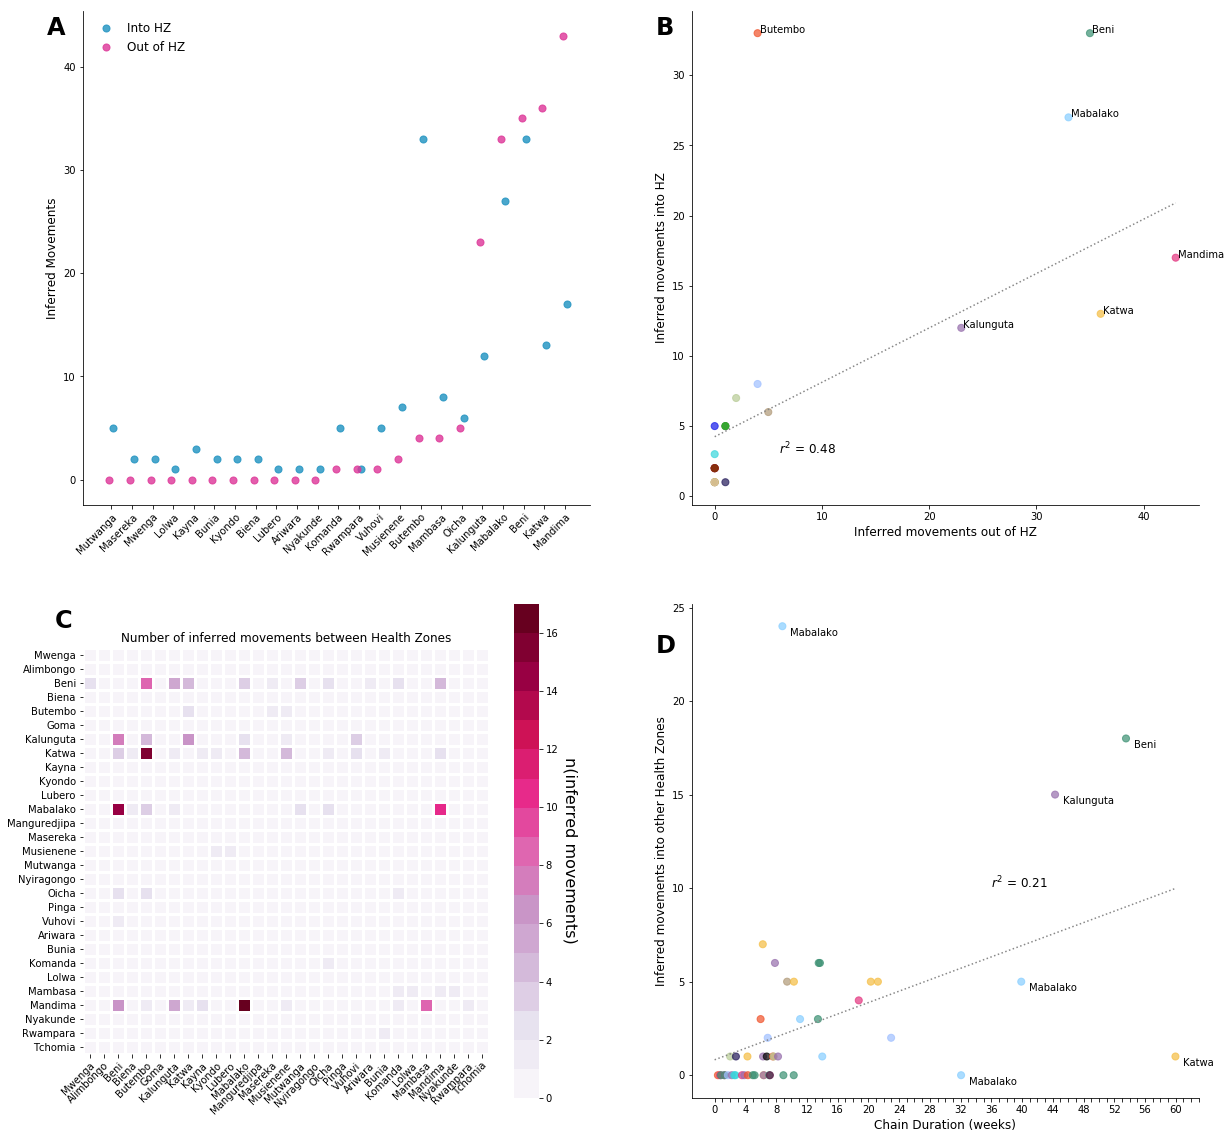

In [173]:
def plot_sup_fig(data, filename=None):


    def plot_transmissions_into_and_outof_each_hz(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        x_labels = sorted(data['demes'], key=lambda d: data['sources'][d])
        x = list(range(0, len(x_labels)))
        y_in = [data['sinks'][d] for d in x_labels]
        y_out = [data['sources'][d] for d in x_labels]
        ax.scatter([xx+0.1 for xx in x], y_in, s=50, c="#1d91c0", alpha=0.8, label="Into HZ") # blue
        ax.scatter([xx-0.1 for xx in x], y_out, s=50, c="#dd3497", alpha=0.8, label="Out of HZ") # pink
        ax.set_ylabel('Inferred Movements', fontsize='large')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax.legend(fontsize='large', frameon=False)
        # analysis of top 5 HZs (last 5 in x)
        print(", ".join(x_labels[len(x)-5:len(x)]), "Into:", sum(y_in[len(x)-5:len(x)]),"/", sum(y_in), "Out-of", sum(y_out[len(x)-5:len(x)]), "/", sum(y_out))
        del x_labels, x, y_in, y_out



    def plot_scatter_transmissions_into_outof(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        sources = data['sources']
        sinks = data['sinks']
        x = []; y = []; colours=[];
        for d in data['demes']:
            print(d)
            x.append(sources[d] if d in sources else 0)
            y.append(sinks[d] if d in sinks else 0)
            colours.append(get_health_zone_colour(d))
        ax.scatter(x, y, s=50, c=colours, alpha=0.7)
        ax.set_xlabel('Inferred movements out of HZ', fontsize='large')
        ax.set_ylabel('Inferred movements into HZ', fontsize='large')
        # annotations
        for d in data['demes']:
            if d in sinks and d in sources and (sinks[d]>10 or sources[d]>10):
                ax.text(sources[d]+0.2, sinks[d], d)
        # L1INEAR REGRESSION:
        linreg = stats.linregress(x, y)
        max_x = max(x)
        ax.plot([0, max_x], [linreg.intercept, max_x*linreg.slope], linestyle=':', color="#878787")
        ax.text(6, 3, r'$r^2$ = %0.2f' % linreg.rvalue**2, fontsize='large')
        print("Transmissions into HZ vs out of HZ, p=", linreg.pvalue)


    def plot_scatter_chain_duration_num_transmissions(ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        chains = sorted(data['chains'], key=lambda c: c["duration"])
        x_data = [num_date_to_weeks(d["duration"]) for d in chains]
        y_data = [d["transmissions_out_of_chain"] for d in chains]
        colours = [get_health_zone_colour(d["hz"]) for d in chains]
        ax.scatter(x_data, y_data, s=50, c=colours, alpha=0.7)
        ax.set_ylabel('Inferred movements into other Health Zones', fontsize='large')
        ax.set_xlabel('Chain Duration (weeks)', fontsize='large')
        ax.set_xticks(list(range(0, 71)))
        ax.set_xticklabels(["" if x%4 else x for x in list(range(0, 71))])
        # L1INEAR REGRESSION:
        linreg = stats.linregress(x_data, y_data)
        ax.plot([0, 60], [linreg.intercept, 60*linreg.slope], linestyle=':', color="#878787")
        ax.text(36, 10, r'$r^2$ = %0.2f' % linreg.rvalue**2, fontsize='large')
        print("Chain duration vs n(Transmissions), p=", linreg.pvalue)
        ## LABEL OUTLIERS
        for outlier in [d for d in chains if (num_date_to_weeks(d["duration"])>30 or d["transmissions_out_of_chain"]>15)]:
            ax.text(num_date_to_weeks(outlier["duration"])+1, outlier["transmissions_out_of_chain"]-0.5, outlier["hz"])
        print("Transmissions contributed by top 5 chains:", sum([y for y in y_data if y>15]), sum(y_data))
        print("Mean number of transmissions:", np.mean(y_data), np.std(y_data))


    def plot_transmission_heatmap(ax):
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['top'].set_visible(False)

        mtx = [[0 for d in demes_ordered] for d in demes_ordered] # len(demes) x len(demes) // from x to
        cc = 0
        for c in data['jumps']:
            if c["parent_hz"] == 'ZOONOSIS':
                continue
            mtx[demes_ordered.index(c["parent_hz"])][demes_ordered.index(c["hz"])] += 1
        mtx = np.array(mtx);
        max_value = np.amax(mtx)

        # discrete colormap via https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
        cmap = plt.cm.PuRd
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
        bounds = np.linspace(0, max_value, max_value+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        im = ax.imshow(mtx, cmap=cmap, norm=norm)
        ax.set_xticks(np.arange(len(demes_ordered)))
        ax.set_yticks(np.arange(len(demes_ordered)))
        ax.set_xticklabels(demes_ordered)
        ax.set_yticklabels(demes_ordered)

        cbar = fig.colorbar(im, ax=ax)
        cbar.outline.set_visible(False)
        cbar.ax.set_ylabel("n(inferred movements)", rotation=-90, va="bottom", fontsize=16)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Turn spines off and create white grid.
        for edge, spine in ax.spines.items():
            spine.set_visible(False)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.set_xticks(np.arange(mtx.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(mtx.shape[0]+1)-.5, minor=True)
        ax.tick_params(which="minor", bottom=False, left=False)

        ax.set_title("Number of inferred movements between Health Zones")




    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    plot_transmissions_into_and_outof_each_hz(ax[0][0])
    plot_scatter_transmissions_into_outof(ax[0][1])
    plot_transmission_heatmap(ax[1][0])
    plot_scatter_chain_duration_num_transmissions(ax[1][1])

    
    # Annotate figure labels
    ax[0][0].text(-0.07, 0.95, 'A', size=24, color='k', weight="bold", transform=ax[0][0].transAxes)
    ax[0][1].text(-0.07, 0.95, 'B', size=24, color='k', weight="bold", transform=ax[0][1].transAxes)
    ax[1][0].text(-0.07, 1.05, 'C', size=24, color='k', weight="bold", transform=ax[1][0].transAxes)
    ax[1][1].text(-0.07, 0.9, 'D', size=24, color='k', weight="bold", transform=ax[1][1].transAxes)
    
    if filename:
        plt.savefig(filename, format="png")
    plt.show()

plot_sup_fig(data=main_data)

## Main figure: KDE presentation of transmission data

Analysis follows from Gytis' notebooks and Figure 3 from Dudas _et al_, Nature, 2017

Inferred movements (straight line distance):
	50%: 50.0 95% 134.0
Inferred movements out of each chain
	50%: 3.1 95% 17.6
Introductions per HZ (jumps into a HZ)
	50%: 7.7 95% 34.1
Chain duration
	50%: 10.25 95% 45.75


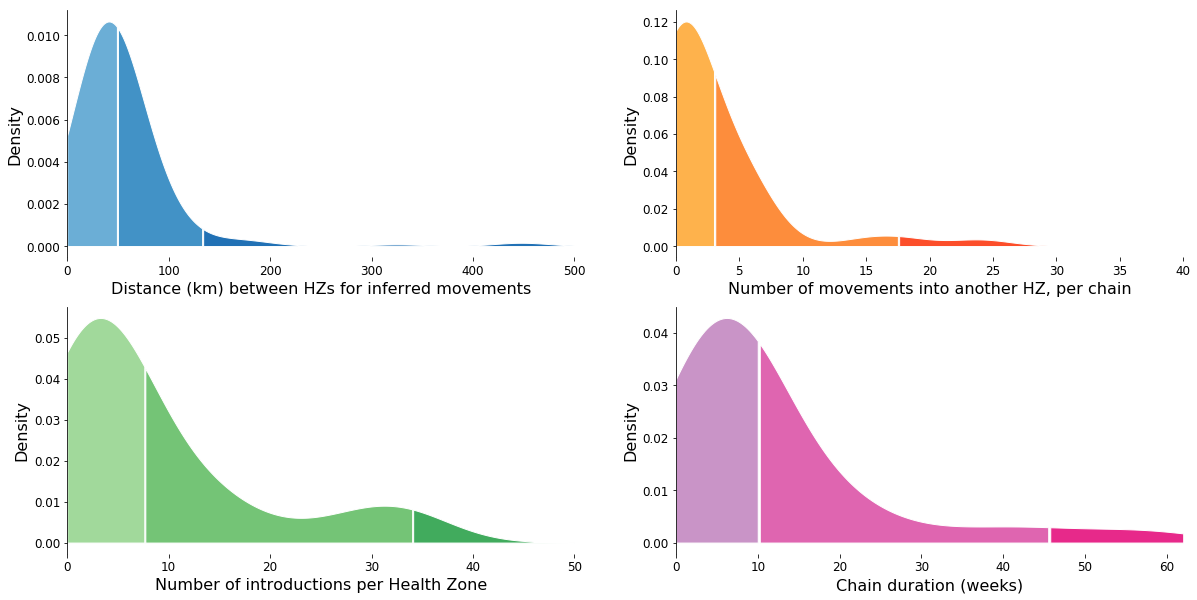

In [174]:
def plot_kdes(data, filename=False):

    def get_kernel(x_grid, _data):
        kde = stats.gaussian_kde(_data, bw_method=0.5) ## estimate kernel from all jump distances
        y_grid=kde.evaluate(x_grid)
        asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral to be between 0.0 and 1.0
        integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in x_grid] ## get normalized integral
        idx50=integral.index(sorted(integral,key=lambda x:abs(x-0.5))[0]) ## identify slice closest to 0.5
        idx95=integral.index(sorted(integral,key=lambda x:abs(x-0.95))[0]) ## identify slice closest to 0.95
        print("\t50%:", x_grid[idx50], "95%", x_grid[idx95])
        return {"kde": kde, "idx50": idx50, "idx95": idx95, "x_grid": x_grid, "y_grid": y_grid}

    def plot_kernel(ax, kernel, colours):
        idx50=kernel["idx50"]; idx95=kernel["idx95"]; x_grid=kernel["x_grid"]; y_grid=kernel["y_grid"]
        ax.fill_between(x_grid[:idx50],      y_grid[:idx50],      facecolor=colours[0], edgecolor='w', lw=1) ## plot pdf 
        ax.fill_between(x_grid[idx50:idx95], y_grid[idx50:idx95], facecolor=colours[1], edgecolor='w', lw=1)
        ax.fill_between(x_grid[idx95:],      y_grid[idx95:],      facecolor=colours[2], edgecolor='w', lw=1)
        # Prettify
        ax.tick_params(axis='x',labelsize=12,direction='out')
        ax.tick_params(axis='y',labelsize=12,direction='out')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.set_xlim(x_grid[0], x_grid[-1])
        for pos in ["top", "right", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_ylabel('Density',size=16)

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), facecolor='w')
    
    print("Inferred movements (straight line distance):")
    transmission_distances = [d for d in [haversine(c["parent_hz"], c["hz"]) for c in data['jumps']] if d];
    transmission_distances_kernel = get_kernel(np.linspace(0.0, 500.0, 501), transmission_distances)
    plot_kernel(ax[0][0], transmission_distances_kernel, ['#6baed6', '#4292c6', '#2171b5']) # Gytis' colours: ['#70BBD4', '#5995A8', '#587680']
    ax[0][0].set_xlabel('Distance (km) between HZs for inferred movements',size=16)

    print("Inferred movements out of each chain")
    transmissions_out_of_a_chain = [c["transmissions_out_of_chain"] for c in data['chains']]
    transmissions_out_of_a_chain_kernel = get_kernel(np.linspace(0.0, 40.0, 401), transmissions_out_of_a_chain)
    plot_kernel(ax[0][1], transmissions_out_of_a_chain_kernel, ['#feb24c', '#fd8d3c', '#fc4e2a'])
    ax[0][1].set_xlabel('Number of movements into another HZ, per chain', size=16)

    print("Introductions per HZ (jumps into a HZ)")
    introductions_per_hz = list(data['sinks'].values())
    introductions_per_hz_kernel = get_kernel(np.linspace(0.0, 50, 501), introductions_per_hz)
    plot_kernel(ax[1][0], introductions_per_hz_kernel, ['#a1d99b', '#74c476', '#41ab5d'])
    ax[1][0].set_xlabel('Number of introductions per Health Zone', size=16)


    print("Chain duration")
    chain_durations = [num_date_to_weeks(c["duration"]) for c in data['chains']]
    chain_durations_kernel = get_kernel(np.linspace(0.0, 62, 249), chain_durations)
    plot_kernel(ax[1][1], chain_durations_kernel, ['#c994c7', '#df65b0', '#e7298a'])
    ax[1][1].set_xlabel('Chain duration (weeks)', size=16)

    if filename:
        plt.savefig(filename, format="png")
    plt.show()

    
plot_kdes(data=main_data, filename="Figure_2_main_dataset.png")

In [ ]:
sub3 = {'jumps': get_jumps("../subsampling-analyses/auspice/ebola-narrative-ms_ThreeperHZmonth.json")}
analyse_jumps(sub3)
plot_kdes(data=sub3, filename="Figure_2_subsampled_n3.png")

sub5 = {'jumps': get_jumps("../subsampling-analyses/auspice/ebola-narrative-ms_FiveperHZmonth.json")}
analyse_jumps(sub5)
plot_kdes(data=sub5, filename="Figure_2_subsampled_n5.png")

In [ ]:
plot_sup_fig(data=main_data, filename="jump_analysis_main_data.png")
plot_sup_fig(data=sub3, filename="jump_analysis_subsampled_n3.png")
plot_sup_fig(data=sub5, filename="jump_analysis_subsampled_n5.png")